The purpose of this notebook is to provide two helper methods (plot and reorder) that can be customised to fit specific document layouts. This type of solutions only apply to textual-images (jpeg or png).

### Dependencies and Methods

In [1]:
import json

from unstructured_inference.inference.layout import DocumentLayout
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
def plot_image_with_bounding_boxes_coloured(image_path, bounding_boxes, text_labels=None, desired_width=None):
    # Load the image
    image = Image.open(image_path)

    if desired_width:
        # Calculate the desired height based on the original aspect ratio
        aspect_ratio = image.width / image.height
        desired_height = desired_width / aspect_ratio

        # Create a figure with the desired size and aspect ratio
        fig, ax = plt.subplots(figsize=(desired_width, desired_height))
    else:
        # Create figure and axes
        fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Split the image vertically
    image_width = image.width
    vertical_line_x = image_width // 2

    # Add bounding boxes and custom text labels to the plot
    for bbox, label in zip(bounding_boxes, text_labels):
        # Extract coordinates
        x_min, y_min = bbox[0]
        x_max, y_max = bbox[2]

        # Calculate width and height
        width = x_max - x_min
        height = y_max - y_min

        # Create a rectangle patch
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='black', facecolor='none')

        # Determine the color based on the position of the bounding box
        if x_min < vertical_line_x and x_max < vertical_line_x:
            # Left side: color is red
            rect.set_edgecolor('red')
            rect.set_facecolor((1.0, 0.0, 0.0, 0.05))

            # Add the rectangle to the plot
            ax.add_patch(rect)
            
            # Add custom text label above the bounding box
            ax.text(x_min, y_min - 5, label, fontsize=12, weight='bold', color='red', bbox=dict(facecolor=(1.0, 1.0, 1.0, 0.8), edgecolor=(0.95, 0.95, 0.95, 0.0), pad=0.5))
        
        elif x_min > vertical_line_x and x_max > vertical_line_x:
            # Right side: color is blue
            rect.set_edgecolor('blue')
            rect.set_facecolor((0.0, 0.0, 1.0, 0.05))

            # Add the rectangle to the plot
            ax.add_patch(rect)
            
            # Add custom text label above the bounding box
            ax.text(x_min, y_min - 5, label, fontsize=12, weight='bold', color='blue', bbox=dict(facecolor=(1.0, 1.0, 1.0, 0.8), edgecolor=(0.95, 0.95, 0.95, 0.0), pad=0.5))
        
        else:
            # Spanning both sides: color is green
            rect.set_edgecolor('green')
            rect.set_facecolor((0.0, 1.0, 0.0, 0.05))

            # Add the rectangle to the plot
            ax.add_patch(rect)

            # Add custom text label above the bounding box
            ax.text(x_min, y_min - 5, label, fontsize=12, weight='bold', color='green', bbox=dict(facecolor=(1.0, 1.0, 1.0, 0.8), edgecolor=(0.95, 0.95, 0.95, 0.0), pad=0.5))

    # Draw the vertical line to split the image
    ax.axvline(x=vertical_line_x, color='black', linestyle='--', linewidth=1)

    # Show the plot
    plt.show()

In [3]:
def reorder_elements_in_double_columns(image_path, bounding_boxes):
    # todo: if first element of left and 
    
    # Load the image
    image = Image.open(image_path)

    # Split the image vertically
    image_width = image.width
    vertical_line_x = image_width // 2

    # Determine the order of the bounding boxes
    left_boxes = []
    right_boxes = []
    both_sided_boxes = []

    new_bounding_boxes_ix = []
    for i, bbox in enumerate(bounding_boxes):
        x_min = bbox[0][0]
        x_max = bbox[-1][0]
        if x_min < vertical_line_x and x_max < vertical_line_x:
            left_boxes.append(i)
        elif x_min > vertical_line_x and x_max > vertical_line_x:
            right_boxes.append(i)
        else:
            both_sided_boxes.append(i)

    # Create new order
    new_bounding_boxes_ix.extend(both_sided_boxes)
    new_bounding_boxes_ix.extend(left_boxes)
    new_bounding_boxes_ix.extend(right_boxes)
    return new_bounding_boxes_ix

### Federal Regulation Documents

In [4]:
image_path = "../../example-docs/double-column-A.jpg"
image = Image.open(image_path)
layout = DocumentLayout.from_image_file(image_path)   # from_file for pdfs
width, height = image.size
print("Width:", width)
print("Height:", height)

Width: 1248
Height: 1664


In [5]:
elements = layout.pages[0].elements

In [6]:
elements_coordinates =[e.to_dict()['coordinates'] for e in elements]
elements_types = [f"{ix}: {e.to_dict()['type']}" for ix, e in enumerate(elements, start=1)]

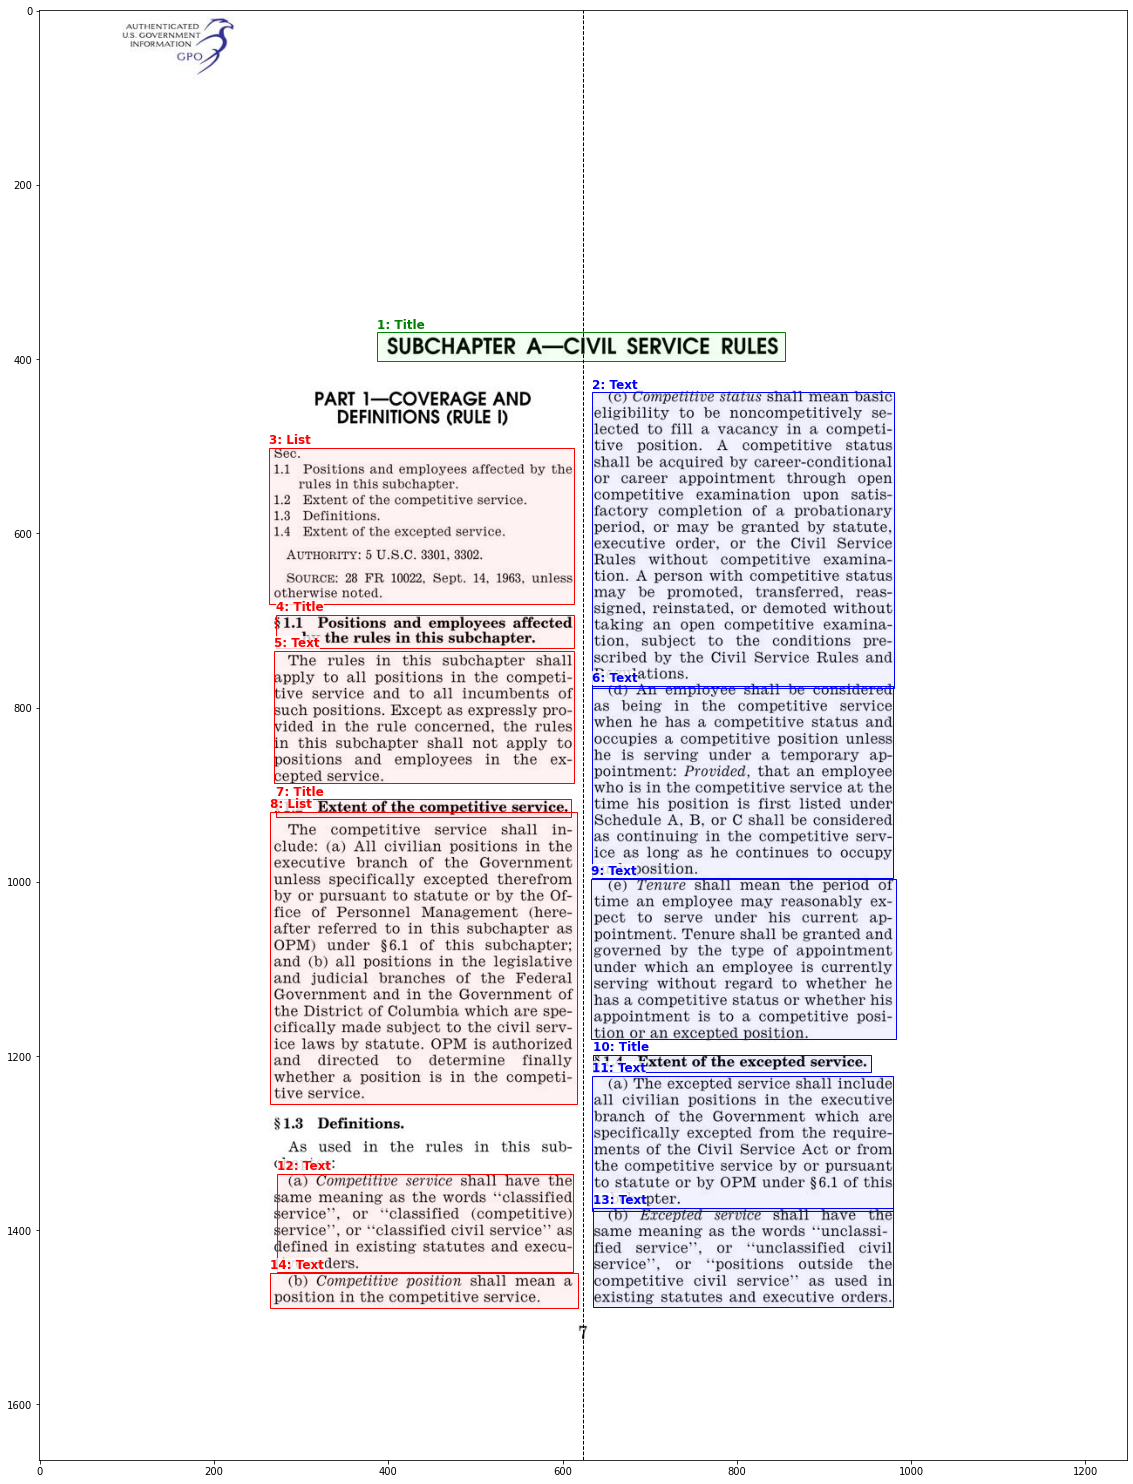

In [7]:
plot_image_with_bounding_boxes_coloured(image_path, elements_coordinates, elements_types, desired_width=20)

In [8]:
new_ixs = reorder_elements_in_double_columns(image_path, elements_coordinates)
new_ixs

[0, 2, 3, 4, 6, 7, 11, 13, 1, 5, 8, 9, 10, 12]

In [9]:
elements_reord = [elements[i] for i in new_ixs]
for ix, (e, e_fix) in enumerate(zip(elements, elements_reord)):
    print(f"\n🔥 element index: {ix}")
    print(json.dumps(e.to_dict(), indent=2))
    print(f"\n🔥🔥 now is:")
    print(json.dumps(e_fix.to_dict(), indent=2))


🔥 element index: 0
{
  "coordinates": [
    [
      387.199541015625,
      369.36095448369565
    ],
    [
      387.199541015625,
      402.3356487771739
    ],
    [
      855.3382690429688,
      402.3356487771739
    ],
    [
      855.3382690429688,
      369.36095448369565
    ]
  ],
  "text": "SUBCHAPTER A\u2014CIVIL SERVICE RULES\n",
  "type": "Title"
}

🔥🔥 now is:
{
  "coordinates": [
    [
      387.199541015625,
      369.36095448369565
    ],
    [
      387.199541015625,
      402.3356487771739
    ],
    [
      855.3382690429688,
      402.3356487771739
    ],
    [
      855.3382690429688,
      369.36095448369565
    ]
  ],
  "text": "SUBCHAPTER A\u2014CIVIL SERVICE RULES\n",
  "type": "Title"
}

🔥 element index: 1
{
  "coordinates": [
    [
      634.0365966796875,
      438.10726147342996
    ],
    [
      634.0365966796875,
      777.8485431763285
    ],
    [
      980.589873046875,
      777.8485431763285
    ],
    [
      980.589873046875,
      438.107261473

In [10]:
elements_coordinates_fix =[e.to_dict()['coordinates'] for e in elements_reord]
elements_types_fix = [f"{ix}: {e.to_dict()['type']}" for ix, e in enumerate(elements_reord, start=1)]

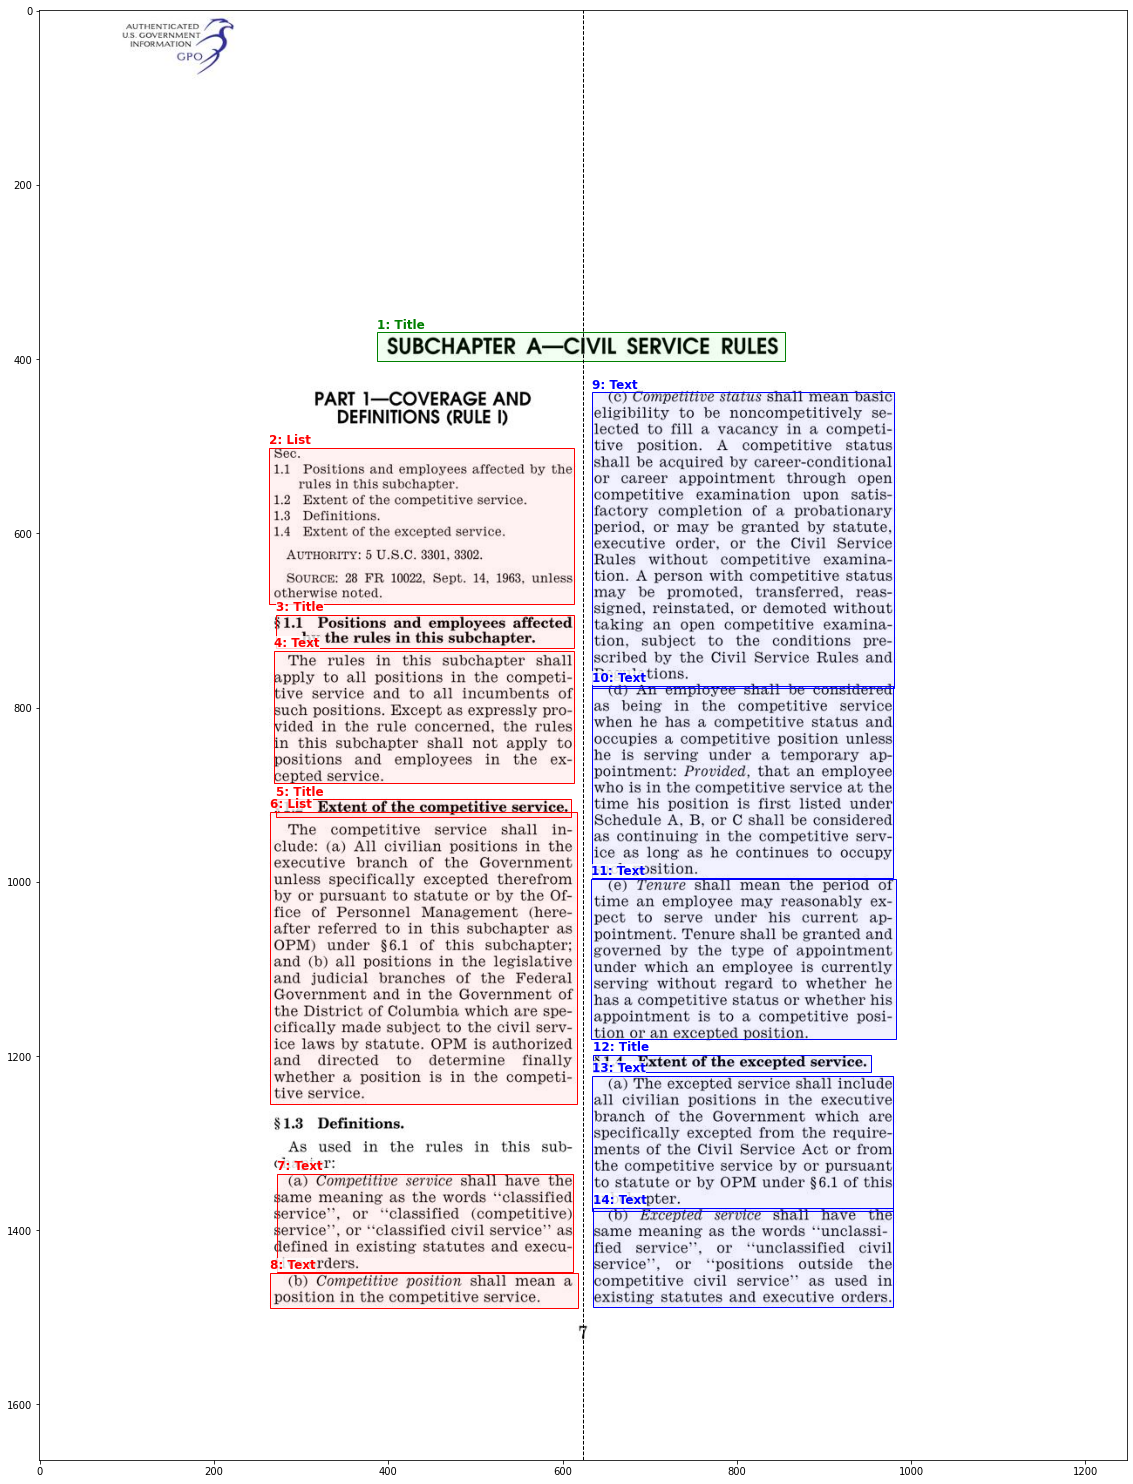

In [11]:
plot_image_with_bounding_boxes_coloured(image_path, elements_coordinates_fix, elements_types_fix, desired_width=20)

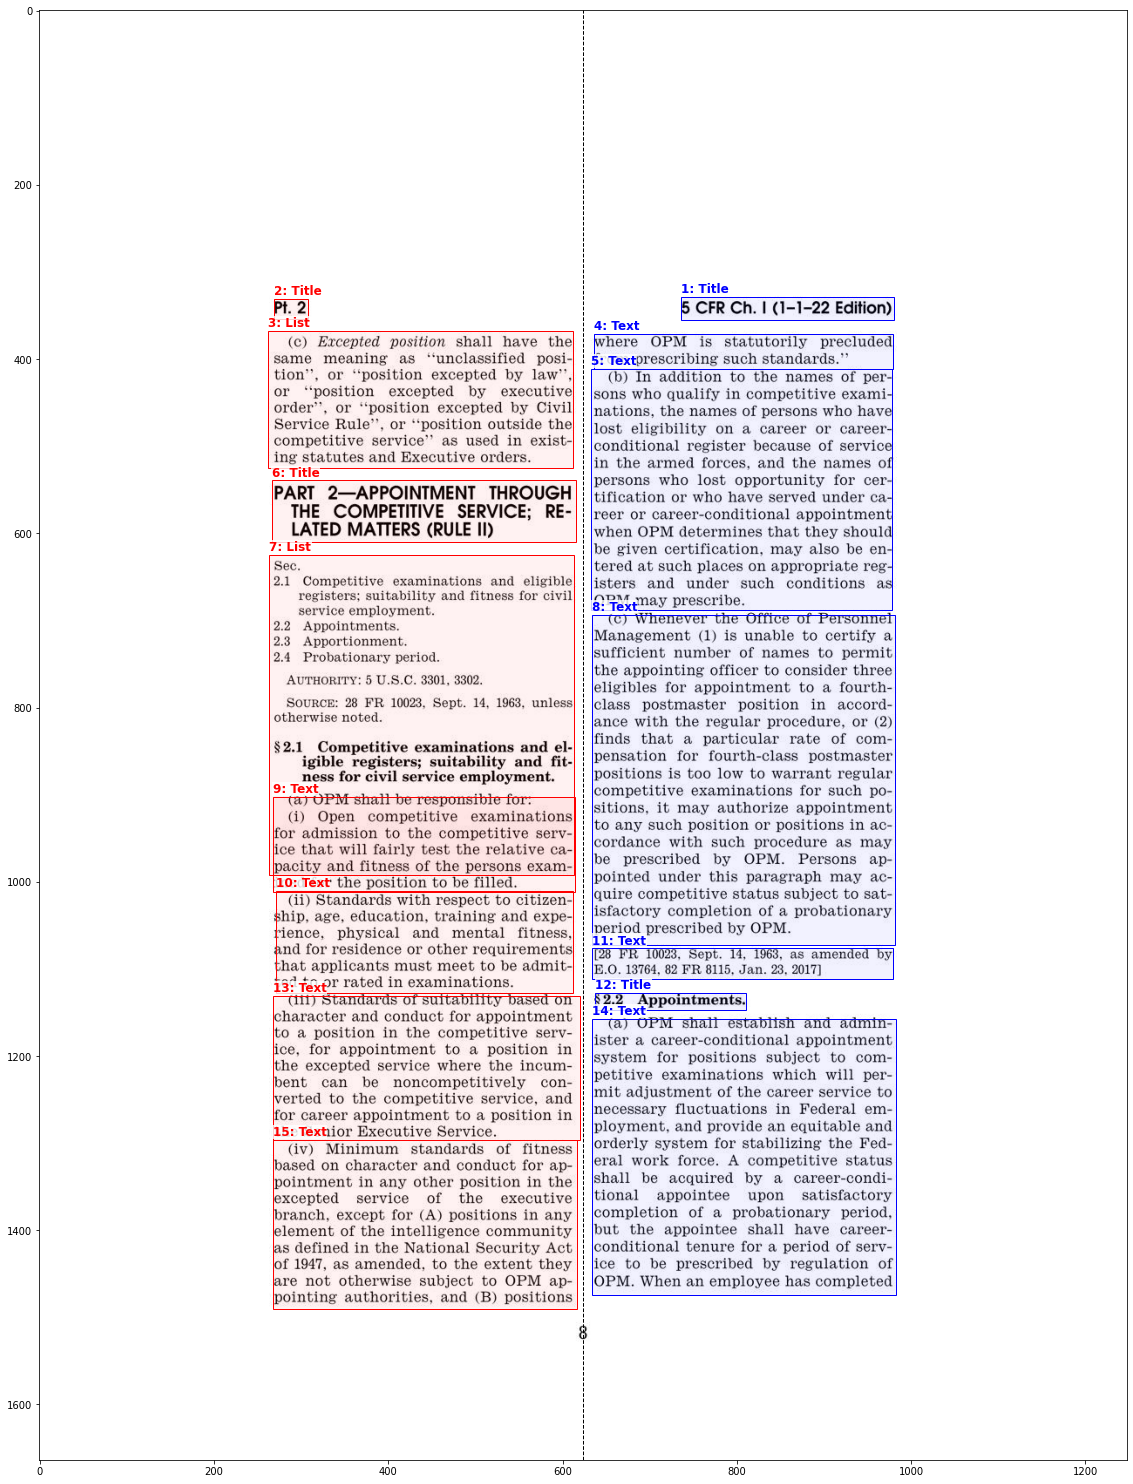

In [12]:
image_path = "../../example-docs/double-column-B.jpg"
image = Image.open(image_path)
layout = DocumentLayout.from_image_file(image_path)   # from_file for pdfs
width, height = image.size
elements = layout.pages[0].elements
elements_coordinates =[e.to_dict()['coordinates'] for e in elements]
elements_types = [f"{ix}: {e.to_dict()['type']}" for ix, e in enumerate(elements, start=1)]
plot_image_with_bounding_boxes_coloured(image_path, elements_coordinates, elements_types, desired_width=20)

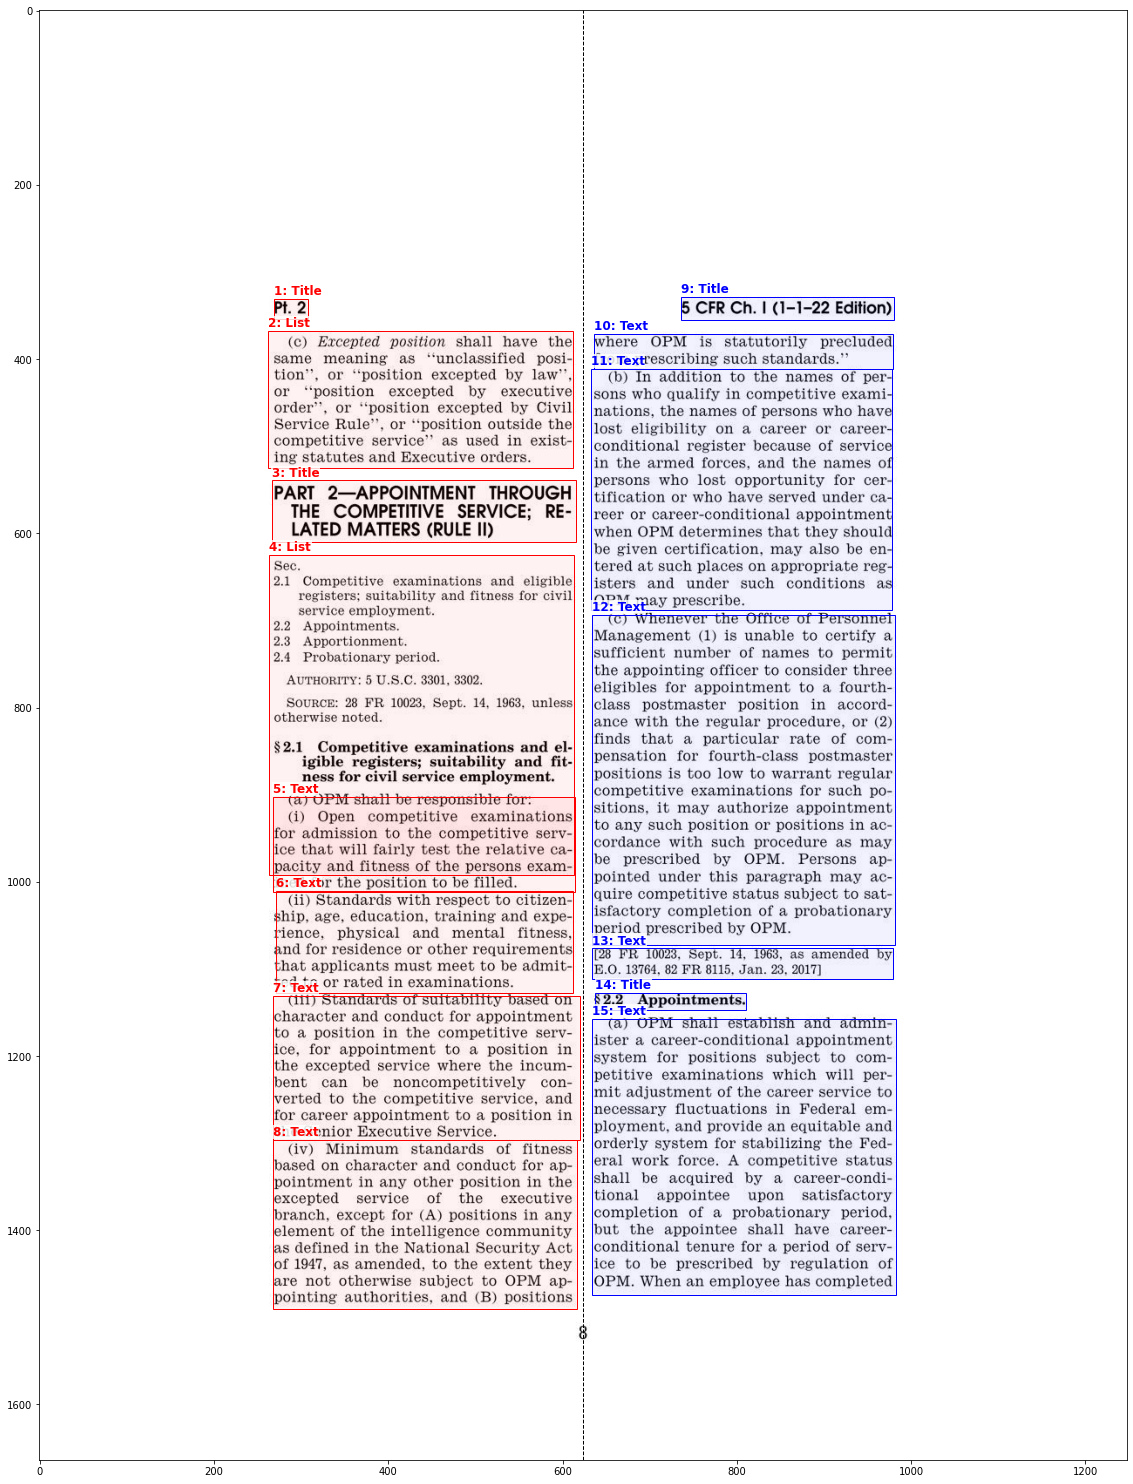

In [13]:
new_ixs = reorder_elements_in_double_columns(image_path, elements_coordinates)
elements_reord = [elements[i] for i in new_ixs]
elements_coordinates_fix =[e.to_dict()['coordinates'] for e in elements_reord]
elements_types_fix = [f"{ix}: {e.to_dict()['type']}" for ix, e in enumerate(elements_reord, start=1)]
plot_image_with_bounding_boxes_coloured(image_path, elements_coordinates_fix, elements_types_fix, desired_width=20)